In [14]:
from astropy.io import fits
from astropy.table import Table
import numpy as np
import matplotlib.pylab as plt 
import matplotlib.lines as mlines
from matplotlib.legend import Legend
from pythonds.basic.stack import Stack
from math import *
from sklearn.neighbors import KDTree
import healpy as hp

length of sdss lrg array:  4851200
length of lrg only array: 1406221
length of row matched targets in SDSS and DECaLS:  4851200
length of DECaLS targets in brick:  4529240
length of id_ALL:  4529240
length of id_MATCHED with LRG_cut (id_LRG): 1586
length of idcut: 4529240
length of idcut = 1 (is an LRG in DECaLS-only file): 1206
length of idcut = 0 (is not an LRG in DECaLS-only file): 4528034
length of z_lrg: 1206
LRGs only
length gobs: 1206
length robs; 1206
length gflux: 1206
length rflux: 1206
length of gmag array =  1206
length of rmag array =  1206
length of color array =  1206
Max gmag =  23.8119
Min gmag =  16.1883
Max rmag =  21.9023
Min rmag =  15.6875
Min color =  -0.47049
Max color =  2.7235

Background only
length gobs: 432226
length robs: 432226
length gflux: 432226
length rflux: 432226
length of gmag array =  432226
length of rmag array =  432226
length of color array =  432226
Max gmag =  36.1604
Min gmag =  8.59715
Max rmag =  35.4178
Min rmag =  7.13431
Min color =  -1

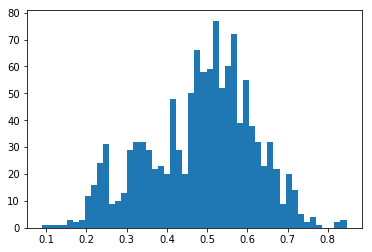

In [15]:
# Reading in data and assigning it to variables even though Greg seems to think it's a waste of time.

# Read in data
# hdulist = fits.open('http://portal.nersc.gov/project/cosmo/data/legacysurvey/dr3/external/survey-dr3-specObj-dr13.fits') # survey
# hdulist2 = fits.open('https://data.sdss.org/sas/dr13/sdss/spectro/redux/specObj-dr13.fits')
# tbdata = hdulist[1].data
# tbdata2 = hdulist2[1].data

hdulist = fits.open('/Users/mtownsend/anaconda/Data/survey-dr5-specObj-dr14.fits') # this matches SDSS LRGs to DECaLS;
                                                                 # ONLY GIVES SOURCES THAT ARE IN SDSS AND DECALS
hdulist2 = fits.open('/Users/mtownsend/anaconda/Data/specObj-dr14.fits') # this is SDSS redshifts etc for LRGs
hdulist3 = fits.open('/Users/mtownsend/anaconda/Data/sweep-240p005-250p010.fits') # this is one brick of the DECaLS data
SpecObj_data = hdulist[1].data
SDSS_data = hdulist2[1].data
DECaLS_data = hdulist3[1].data

# print(len(SpecObj_data))
# print(len(SDSS_data))
# print(len(DECaLS_data))

# Put data in arrays

# Read in data from SDSS file

# Redshift of galaxies according to sdss
z = []
z = SDSS_data.field('Z') 

# Class of object
gal_class = []
gal_class = SDSS_data.field('CLASS')

# What survey the data is from
survey = []
survey = SDSS_data.field('SURVEY')

# SPECPRIMARY; set to 1 for primary observation of object, 0 otherwise
spec = []
spec = SDSS_data.field('SPECPRIMARY')

# Bitmask of spectroscopic warning values; need set to 0
zwarn_noqso = []
zwarn_noqso = SDSS_data.field('ZWARNING_NOQSO')

# Spectroscopic classification for certain redshift?
class_noqso = []
class_noqso = SDSS_data.field('CLASS_NOQSO')

# Array for LRG targets
targets = []
targets = SDSS_data.field('BOSS_TARGET1')

# Section of code to find LRG targets

def divideBy2(decNumber):

	# from pythonds.basic.stack import Stack
# 	import numpy as np

	np.vectorize(decNumber)  
	remstack = Stack()
	
	if decNumber == 0: return "0"
	
	while decNumber > 0:
		rem = decNumber % 2
		remstack.push(rem)
		decNumber = decNumber // 2
		
	binString = ""
	while not remstack.isEmpty():
		binString = binString + str(remstack.pop())
			
	return binString
	
	
	
# Function to find LOWZ targets
divideBy2Vec = np.vectorize(divideBy2)

a = divideBy2Vec(targets) # gives binary in string form

b = []
c = []

for i in range(len(a)):
	b.append(list((a[i])))
	b[i].reverse()
	
# print(b)

lrg = []

# Finds flags for BOSS LOWZ and CMASS sample
for i in range(len(b)):
	try:
		if (b[i][0] == '1') or (b[i][1] == '1'):
			lrg.append(int(1))
		else:
			lrg.append(int(0))
	except IndexError:
		pass
# 		print('pass statement')
		lrg.append(int(0))
		
lrg = np.array(lrg)
print('length of sdss lrg array: ', len(lrg))
print('length of lrg only array:', len(lrg[np.where(lrg == 1)]))

# ------------------------------------------------------------------------------------------------------------

# Read in data from SDSS row matched DECaLS file

# Object ID from survey file; value -1 for non-matches
objid_MATCHED = []
objid_MATCHED = SpecObj_data.field('OBJID')
# print(len(objid_LRG))
# print(type(objid_LRG[1]))

# Add bridkid
brickid_MATCHED = []
brickid_MATCHED = SpecObj_data.field('BRICKID')
# print(len(brickid_LRG))

# Add brickname
brickname_MATCHED = []
brickname_MATCHED = SpecObj_data.field('BRICKNAME')

# Only galaxies included
gal_type_MATCHED = []
gal_type_MATCHED = SpecObj_data.field('TYPE') 

# RA
ra_MATCHED = []
ra_MATCHED = SpecObj_data.field('RA')

# Dec
dec_MATCHED = []
dec_MATCHED = SpecObj_data.field('DEC')

# flux_g
gflux_MATCHED = []
gflux_MATCHED = SpecObj_data.field('FLUX_G')

# flux_r
rflux_MATCHED = []
rflux_MATCHED = SpecObj_data.field('FLUX_R')

# flux_z
zflux_MATCHED = []
zflux_MATCHED = SpecObj_data.field('FLUX_Z')

# nobs == number of images that contribute to the central pixel
# nobs_g
gobs_MATCHED = []
gobs_MATCHED = SpecObj_data.field('NOBS_G')

# nobs_r
robs_MATCHED = []
robs_MATCHED = SpecObj_data.field('NOBS_R')

# nobs_z
zobs_MATCHED = []
zobs_MATCHED = SpecObj_data.field('NOBS_Z')

# Create a unique identifier by combinding BRICKID and OBJID

id_MATCHED = []

for i in range(len(objid_MATCHED)):
    if (objid_MATCHED[i] == -1):
        id_MATCHED.append(-1)
    else:
        temp1 = str(brickid_MATCHED[i]) + str(objid_MATCHED[i])
        id_MATCHED.append(temp1)

print('length of row matched targets in SDSS and DECaLS: ', len(id_MATCHED)) 
id_MATCHED = np.array(id_MATCHED)
# ------------------------------------------------------------------------------------------------------------

# Read in data from DECaLS bricks

# Object ID from survey file; value -1 for non-matches
objid_ALL = []
objid_ALL = DECaLS_data.field('OBJID')
# print(len(objid_ALL))

# Add bridkid
brickid_ALL = []
brickid_ALL = DECaLS_data.field('BRICKID')
# print(len(brickid_ALL))

# Add brickname
brickname_ALL = []
brickname_ALL = DECaLS_data.field('BRICKNAME')

# Only galaxies included
gal_type_ALL = []
gal_type_ALL = DECaLS_data.field('TYPE') 

# RA
ra_ALL = []
ra_ALL = DECaLS_data.field('RA')

# Dec
dec_ALL = []
dec_ALL = DECaLS_data.field('DEC')

# flux_g
gflux_ALL = []
gflux_ALL = DECaLS_data.field('FLUX_G')

# flux_r
rflux_ALL = []
rflux_ALL = DECaLS_data.field('FLUX_R')

# flux_z
zflux_ALL = []
zflux_ALL = DECaLS_data.field('FLUX_Z')

# nobs == number of images that contribute to the central pixel
# nobs_g
gobs_ALL = []
gobs_ALL = DECaLS_data.field('NOBS_G')

# nobs_r
robs_ALL = []
robs_ALL = DECaLS_data.field('NOBS_R')

# nobs_z
zobs_ALL = []
zobs_ALL = DECaLS_data.field('NOBS_Z')

id_ALL = []

for i in range(len(objid_ALL)):
    temp2 = str(brickid_ALL[i]) + str(objid_ALL[i])
    id_ALL.append(temp2)
    
print('length of DECaLS targets in brick: ', len(id_ALL))

id_ALL = np.array(id_ALL)

print('length of id_ALL: ', len(id_ALL))

# ------------------------------------------------------------------------------------------------------------

# Make cuts to separate LRGs and background galaxies

LRG_cut = ((gobs_MATCHED >= 3.) & (robs_MATCHED >= 3.) & (gflux_MATCHED > 0.) & (rflux_MATCHED > 0.) & (objid_MATCHED > -1) & (lrg == 1) & ((gal_type_MATCHED == 'SIMP') | (gal_type_MATCHED == "DEV") | (gal_type_MATCHED == "EXP") | (gal_type_MATCHED == "REX")) & (ra_MATCHED >= 241) & (ra_MATCHED <= 246) & (dec_MATCHED >= 6.5) & (dec_MATCHED <= 11.5) & (gal_class == 'GALAXY') & (spec == 1 ) & (zwarn_noqso == 0) & (class_noqso == 'GALAXY') & ((survey == 'sdss') | (survey == 'boss')))

id_LRG = []
id_LRG = np.array(id_LRG)
id_LRG = id_MATCHED[np.where(LRG_cut)]
print('length of id_MATCHED with LRG_cut (id_LRG):', len(id_LRG))

idcut = []

# This creates a list that is the length of id_ALL that matches LRGs from the DECaLS/SDSS file to the DECaLS file
# Use id_cut_noLRG == 0 to get galaxy sources that are NOT identified LRGs 
# For use in narrowing down DECaLS-only file (ie 'ALL')
for i in range(len(id_ALL)):
    if any(id_LRG == id_ALL[i]):
        idcut.append(1)
    else:
        idcut.append(0)

idcut = np.array(idcut)
print('length of idcut:', len(idcut))
print('length of idcut = 1 (is an LRG in DECaLS-only file):', len(idcut[np.where(idcut == 1)]))
print('length of idcut = 0 (is not an LRG in DECaLS-only file):', len(idcut[np.where(idcut == 0)]))

idcut1 = idcut[np.where(idcut == 1)] 

z_lrg = []
ra_lrg = []
dec_lrg = []
for i in range(len(id_ALL)):
    if (idcut[i] == 1):
        z_lrg.append(z[np.where(id_MATCHED == id_ALL[i])])
        ra_lrg.append(ra_MATCHED[np.where(id_MATCHED == id_ALL[i])])
        dec_lrg.append(dec_MATCHED[np.where(id_MATCHED == id_ALL[i])])

print('length of z_lrg:', len(z_lrg))
z_lrg = np.array(z_lrg)
ra_lrg = np.array(ra_lrg)
dec_lrg = np.array(dec_lrg)

# LRG_cut = ((id_cut_LRG == 1) & (gobs_MATCHED >= 3.) & (robs_MATCHED >= 3.) & (gflux_MATCHED > 0.) & (rflux_MATCHED > 0.) & (objid_MATCHED > -1) & (lrg == 1) & ((gal_type_MATCHED == 'SIMP') | (gal_type_MATCHED == "DEV") | (gal_type_MATCHED == "EXP") | (gal_type_MATCHED == "REX")) & (ra_MATCHED >= 241) & (ra_MATCHED <= 246) & (dec_MATCHED >= 6.5) & (dec_MATCHED <= 11.5) & (gal_class == 'GALAXY') & (spec == 1 ) & (zwarn_noqso == 0) & (class_noqso == 'GALAXY') & ((survey == 'sdss') | (survey == 'boss')))
# & (brickid_LRG == brickid_ALL)
# print(len(LOWZ_cut))

# Cut out LRGs
no_LRG_cut = ((idcut == 0) & (gobs_ALL >= 3.) & (robs_ALL >= 3.) & (gflux_ALL > 0.) & (rflux_ALL > 0.) & ((gal_type_ALL == 'SIMP') | (gal_type_ALL == "DEV") | (gal_type_ALL == "EXP") | (gal_type_ALL == "REX")) & (ra_ALL >= 241) & (ra_ALL <= 246) & (dec_ALL >= 6.5) & (dec_ALL <= 11.5))

# Flux cuts

# Flux in g for only LRGs
gflux_LRG = gflux_ALL[np.where(idcut == 1)]

# Flux in r for only LRGs
rflux_LRG = rflux_ALL[np.where(idcut == 1)]

# Flux in g for only LRGs
zflux_LRG = zflux_ALL[np.where(idcut == 1)]

# Flux in g for all galaxies in DECaLS
gflux_BKG = gflux_ALL[np.where(no_LRG_cut)]

# Flux in r for all galaxies in DECaLS
rflux_BKG = rflux_ALL[np.where(no_LRG_cut)]

# Flux in z for all galaxies in DECaLS
zflux_BKG = zflux_ALL[np.where(no_LRG_cut)]


# Obs cuts

# Number of images in g for only LRGs
gobs_LRG = gobs_ALL[np.where(idcut == 1)]

# Number of images in r for only LRGs
robs_LRG = robs_ALL[np.where(idcut == 1)]

# Number of images in g for only LRGs
zobs_LRG = zobs_ALL[np.where(idcut == 1)]

# Number of images in g for all galaxies in DECaLS
gobs_BKG = gobs_ALL[np.where(no_LRG_cut)]

# Number of images in r for all galaxies in DECaLS
robs_BKG = robs_ALL[np.where(no_LRG_cut)]

# Number of images in z for all galaxies in DECaLS
zobs_BKG = zobs_ALL[np.where(no_LRG_cut)]

print('LRGs only')
print('length gobs:', len(gobs_LRG))
print('length robs;', len(robs_LRG))
print('length gflux:', len(gflux_LRG))
print('length rflux:', len(rflux_LRG))

gmag_LRG = 22.5 - 2.5 * np.log10(gflux_LRG)
rmag_LRG = 22.5 - 2.5 * np.log10(rflux_LRG)

color_LRG = gmag_LRG - rmag_LRG

print("length of gmag array = ", len(gmag_LRG))
print("length of rmag array = ",len(rmag_LRG))
print("length of color array = ", len(color_LRG))
print("Max gmag = ", np.amax(gmag_LRG))
print("Min gmag = ", np.amin(gmag_LRG))
print("Max rmag = ", np.amax(rmag_LRG))
print("Min rmag = ", np.amin(rmag_LRG))
print("Min color = ", np.amin(color_LRG))
print("Max color = ", np.amax(color_LRG))
print("")
print('Background only')
print('length gobs:', len(gobs_BKG))
print('length robs:', len(robs_BKG))
print('length gflux:', len(gflux_BKG))
print('length rflux:', len(rflux_BKG))

gmag_BKG = 22.5 - 2.5 * np.log10(gflux_BKG)
rmag_BKG = 22.5 - 2.5 * np.log10(rflux_BKG)

color_BKG = gmag_BKG - rmag_BKG

print("length of gmag array = ", len(gmag_BKG))
print("length of rmag array = ",len(rmag_BKG))
print("length of color array = ", len(color_BKG))
print("Max gmag = ", np.amax(gmag_BKG))
print("Min gmag = ", np.amin(gmag_BKG))
print("Max rmag = ", np.amax(rmag_BKG))
print("Min rmag = ", np.amin(rmag_BKG))
print("Min color = ", np.amin(color_BKG))
print("Max color = ", np.amax(color_BKG))

print("")
# Only LRGs
print("")
print("Only LRGs")
print("Max z = ", np.amax(z))
print("Min z = ", np.amin(z))
plt.hist(z_lrg, bins=50)
plt.show()

In [16]:
# cosmoCalc function to find scale (kpc_DA)
# This is a modified Python Code for this cosmological calculator (http://www.astro.ucla.edu/~wright/CC.python),
# Which is in turn modified from http: http://www.astro.ucla.edu/~wright/CosmoCalc.html. 

# I know this isn't ideal but for some reason the function won't import, even though it imports just fine in other
# files in the same directory

def cosmoCalcfunc(z):
    import numpy as np
    from math import sqrt
    from math import exp
    from math import sin
    from math import pi

# Calculate scale to get areas
    H0 = 69.6
    WM = 0.286
    WV = 0.714
# z = 0.209855

# initialize constants

    WR = 0.        # Omega(radiation)
    WK = 0.        # Omega curvaturve = 1-Omega(total)
    c = 299792.458 # velocity of light in km/sec
    Tyr = 977.8    # coefficent for converting 1/H into Gyr
    DTT = 0.5      # time from z to now in units of 1/H0
    DTT_Gyr = []  # value of DTT in Gyr
    age = 0.5      # age of Universe in units of 1/H0
    age_Gyr = []  # value of age in Gyr
    zage = 0.1     # age of Universe at redshift z in units of 1/H0
    zage_Gyr = [] # value of zage in Gyr
    DCMR = 0.0     # comoving radial distance in units of c/H0
    DCMR_Mpc = [] 
    DCMR_Gyr = []
    DA = 0.0       # angular size distance
    DA_Mpc = []
    DA_Gyr = []
    kpc_DA = []
    DL = 0.0       # luminosity distance
    DL_Mpc = []
    DL_Gyr = []   # DL in units of billions of light years
    V_Gpc = []
    a = 1.0        # 1/(1+z), the scale factor of the Universe
    az = 0.5       # 1/(1+z(object))

    h = H0/100.
    WR = 4.165E-5/(h*h)   # includes 3 massless neutrino species, T0 = 2.72528
    WK = 1-WM-WR-WV

    for j in range(len(z)):
        az = 1.0/(1+1.0*z[j])
        age = 0.
        n=1000         # number of points in integrals
        for i in range(n):
            a = az*(i+0.5)/n
            adot = sqrt(WK+(WM/a)+(WR/(a*a))+(WV*a*a))
            age = age + 1./adot

        zage = az*age/n
        zage_Gyr.append((Tyr/H0)*zage)
        DTT = 0.0
        DCMR = 0.0

	# do integral over a=1/(1+z) from az to 1 in n steps, midpoint rule
        for i in range(n):
            a = az+(1-az)*(i+0.5)/n
            adot = sqrt(WK+(WM/a)+(WR/(a*a))+(WV*a*a))
            DTT = DTT + 1./adot
            DCMR = DCMR + 1./(a*adot)

        DTT = (1.-az)*DTT/n
        DCMR = (1.-az)*DCMR/n
        age = DTT+zage
        age_Gyr.append(age*(Tyr/H0))
        DTT_Gyr.append((Tyr/H0)*DTT)
        DCMR_Gyr.append((Tyr/H0)*DCMR)
        DCMR_Mpc.append((c/H0)*DCMR)

	# tangential comoving distance

        ratio = 1.00
        x = sqrt(abs(WK))*DCMR
        if x > 0.1:
            if WK > 0:
                ratio =  0.5*(exp(x)-exp(-x))/x 
            else:
                ratio = sin(x)/x
        else:
            y = x*x
            if WK < 0: y = -y
            ratio = 1. + y/6. + y*y/120.
        DCMT = ratio*DCMR
        DA = az*DCMT
        DA_Mpc.append((c/H0)*DA)
        kpc_DA.append(DA_Mpc[j]/206.264806)
        DA_Gyr.append((Tyr/H0)*DA)
        DL = DA/(az*az)
        DL_Mpc.append((c/H0)*DL)
        DL_Gyr.append((Tyr/H0)*DL)

	# comoving volume computation

        ratio = 1.00
        x = sqrt(abs(WK))*DCMR
        if x > 0.1:
            if WK > 0:
                ratio = (0.125*(exp(2.*x)-exp(-2.*x))-x/2.)/(x*x*x/3.)
            else:
                ratio = (x/2. - sin(2.*x)/4.)/(x*x*x/3.)
        else:
            y = x*x
            if WK < 0: y = -y
            ratio = 1. + y/5. + (2./105.)*y*y
        VCM = ratio*DCMR*DCMR*DCMR/3.
        V_Gpc.append(4.*pi*((0.001*c/H0)**3)*VCM)
        
    return(DTT_Gyr, age_Gyr, zage_Gyr, DCMR_Mpc, DCMR_Gyr, DA_Mpc, DA_Gyr, kpc_DA, DL_Mpc, DL_Gyr, V_Gpc)

DTT_Gyr, age_Gyr, zage_Gyr, DCMR_Mpc, DCMR_Gyr, DA_Mpc, DA_Gyr, kpc_DA, DL_Mpc, DL_Gyr, V_Gpc = cosmoCalcfunc(z_lrg)

H:
[[  0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    3.00000000e+00   5.40000000e+01   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    1.80000000e+01   9.29000000e+02   1.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    4.70000000e+01   1.71700000e+03   1.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00   1.00000000e+00
    2.09000000e+02   5.75100000e+03   4.90000000e+01   3.00000000e+00
    1.00000000e+00   0.00000000e+00]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00   1.50000000e+01
    9.12000000e+02   6.75920000e+04   2.32000000e+02   2.00000000e+01
    5.00000000e+00   0.00000000e+00]
 [  0.00000000e+00   0.00000000e+00   1.00000000e+00   5.10000000e+01
    1.12840000e+04   2.71527000e+05   7.52

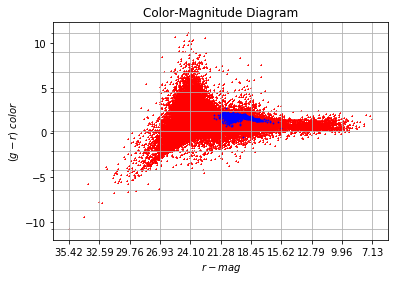

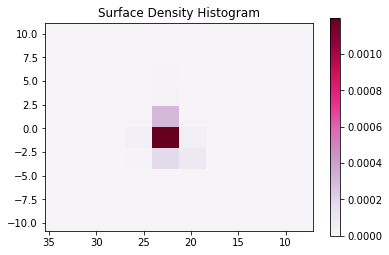

In [35]:
# Create a 2D histogram that creates evenly-spaced bins and counts the points in each bin. H is the matrix 
# with the number of points per bin. Uses this number to calculate the surface density, by dividing the number
# of sources per bin by the area of the EDR. (This is done for every bin.)

# Histogram in color-magnitude space

# Create a 2D histogram that creates evenly-spaced bins and counts the points in each bin
# H is the matrix with the number of points per bin
# xedges, yedges are the bounds of the bins
row = 10
column = 10
# creates histogram for survey sources; excluses LRGs
H, xedges, yedges = np.histogram2d(rmag_BKG, color_BKG, normed=False)
print("H:")
print(H)
print('-------')
print('shape H')
print(np.shape(H))

# Uses the numbers counted in the histogram to calculate a surface density: For each cell, the number of sources
# divided by the area 
sd = H/(17.5 * (3600.**2.)) # converts 25 square degrees to square arcseconds
print("sd:")
print(sd)
print('-------')

# Scatter plot of points with bin lines drawn
fig, ax = plt.subplots()
ax.set_xticks(xedges, minor=False)
ax.set_yticks(yedges, minor=True)
ax.xaxis.grid(True, which='major')
ax.yaxis.grid(True, which='minor')

plt.scatter(rmag_BKG, color_BKG, s = 1, marker = '+', color='red')
plt.scatter(rmag_LRG, color_LRG, s = 1, marker = '*', color='blue')
plt.gca().invert_xaxis()
plt.title("Color-Magnitude Diagram")
plt.xlabel(r'$r-mag$')
plt.ylabel(r'$(g-r)$ $color$')
plt.show()

# color codes bins by surface density with color bar; should make sense when compared to scatter plot
plt.imshow(sd, cmap=plt.cm.PuRd, extent=(xedges[0], xedges[len(xedges)-1], yedges[0], yedges[len(yedges)-1]))
plt.colorbar(orientation='vertical')
plt.gca().invert_xaxis()
plt.title("Surface Density Histogram")
plt.show()

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'list'>
<class 'list'>
length ra_lrg: 1206
length dec_lrg: 1206
length ra_BKG: 432226
length dec_BKG: 432226
length dist: 1206
<class 'numpy.ndarray'>


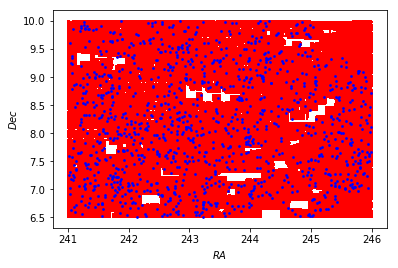

(241.72451005139712, 9.6283575209879491)
<class 'tuple'>
<class 'tuple'>
len zip_list_lrg 1206


In [49]:
# Counting NEAR NEIGHBORS (nn) using KDTree
# Result is an array of the number of near neighbors each LRG has

ra_BKG = ra_ALL[np.where(no_LRG_cut)]
dec_BKG = dec_ALL[np.where(no_LRG_cut)]

ra_lrg = np.array(ra_lrg)
dec_lrg = np.array(dec_lrg)

# ra_lrg = np.concatenate(ra_lrg)
print(type(ra_lrg))
# dec_lrg = np.concatenate(dec_lrg)
print(type(dec_lrg))
ra_BKG = list(ra_BKG)
print(type(ra_BKG))
dec_BKG = list(dec_BKG)
print(type(dec_BKG))

print("length ra_lrg:", len(ra_lrg))
print("length dec_lrg:", len(dec_lrg))
print("length ra_BKG:", len(ra_BKG))
print("length dec_BKG:", len(dec_BKG))

# Distance from which we are looking for satellites around the LRGs
distance = 0.5 # in Mpc
distance_kpc = distance * 10.**3. # in kpc

dist = []
for i in range(len(kpc_DA)):
    dist.append((distance_kpc / kpc_DA[i]) * 1./3600.) 
    
dist = np.concatenate(dist)
print('length dist:', len(dist))

print(type(dist))    
# Plot RA/Dec plot with circles around LRGs
# Plots LRG sources and EDR sources
plt.scatter(ra_BKG, dec_BKG, s = 3, marker = '+', color='red')
plt.scatter(ra_lrg, dec_lrg, s = 3, marker = 'o', color='blue')
# Draws circle of some radius around the LRG sources
# Circles too small to really see in the plot, but I have tested it with bigger radii to make sure it works if I
# ever need it.
# circle = []
# for i in range(len(ra_LRG)):
#     circle = plt.Circle((ra_LRG[i],dec_LRG[i]), dist[i], color='green', fill=False)
#     plt.gcf().gca().add_artist(circle)

plt.xlabel(r'$RA$')
plt.ylabel(r'$Dec$')
plt.show()

# Creates a list of ordered pairs; zips ra and dec together so they can be fed into KDTree
zip_list_lrg = list(zip(ra_lrg, dec_lrg)) # Fake LRG sources
zip_list_BKG = list(zip(ra_BKG, dec_BKG)) # Fake EDR sources
# print(zip_list_lrg)
# print(type(zip_list_BKG))
print(zip_list_lrg[0])
print(type(zip_list_lrg[0]))
print(type(zip_list_BKG[0]))
print('len zip_list_lrg', len(zip_list_lrg))

# Creates a tree of EDR sources
gal_tree = KDTree(zip_list_BKG)

# returns a list of EDR sources that are within some radius r of an LRG
nn = gal_tree.query_radius(zip_list_lrg,r=dist,count_only=True)

# find indices of near neighbors
# creates a list of arrays that include the indices of satellite galaxies per LRG. In general, some or all of these
# arrays could be empty
ind = gal_tree.query_radius(zip_list_lrg,r=dist)
# print(ind)
# print(type(ind[5]))
# ind5 = ind[0]
# print(ind5)
# print(type(ind5[0]))

# Creates one list of number of near neighbors for every LRG (number of lists = number of LRGs)
# NEAR is the list of 2D arrays of satellite galaxies as a funciton of color and magnitude
near = []

for i in range(len(ind)):
    # Creates a zero array if there are no near neighbors
    if len(ind[i]) == 0:
        hist2d = np.zeros((len(xedges)-1,len(yedges)-1))
        near.append(hist2d)
    # Creates a 2D histogram for satellite galaxies
    else:
        hist2d, x_notuse, y_notuse = np.histogram2d(rmag_BKG[ind[i]], color_BKG[ind[i]], bins=(xedges, yedges), normed=False)
        near.append(hist2d)


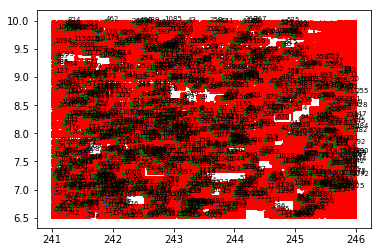

In [39]:
# Calculates NUMBER OF EXPECTED INTERLOPER GALAXIES (Nbkg) by first calculating the solid angle omega enclosed in 
# radius distance_kpc from the LRG. Then find the number of interloper galaxies by multiplying omega by the surface 
# density to find the number of interloper galaxies as a function of color and magnitude.

# Calculate solid angle omega for every radius ()
omega = []

for i in range(len(kpc_DA)):
    omega.append((np.pi * distance_kpc**2.)/(kpc_DA[i])**2.) # in square arcsec

# Multiply omega by the surface density
Nbkg = []

for i in range(len(omega)):
    Nbkg.append(sd * omega[i])
    
# Plots LRG sources and EDR sources
plt.scatter(ra_BKG, dec_BKG, s = 1, marker = '+', color='red')
plt.scatter(ra_lrg, dec_lrg, s = 1, marker = '*', color='blue')

# Plots circles around LRG sources 
circle = []
for i in range(len(ra_lrg)):
    circle = plt.Circle((ra_lrg[i],dec_lrg[i]), dist[i], color='green', fill=False)
    plt.gcf().gca().add_artist(circle)
    
# prints ID numbers next to LRG
# This will be slightly different when using real data because those sources have real ID numbers
a = np.arange(0,len(ra_lrg))
for i, txt in enumerate(a):
    text = plt.annotate(txt, (ra_lrg[i],dec_lrg[i]))
    text.set_fontsize(7)

plt.show()


In [40]:
# Calculate NUMBER OF SATELLITE GALAXIES (Nsat) by subtracting interloper galaxies from near neighbor galaxies as a 
# function of color and magnitude.

Nsat = np.array(near) - np.array(Nbkg)
print(len(Nsat))

1206


mean near neighbor is 60.043946932
standard deviation of near neighbor is 44.7114265858
mean interloper is 48.6110313225
standard deviation of interloper is 29.8263083446
mean number of satellites is 11.4329156096
standard deviation of satellites is 25.6684289085


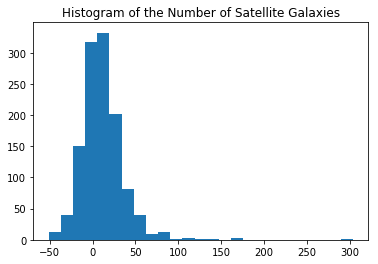

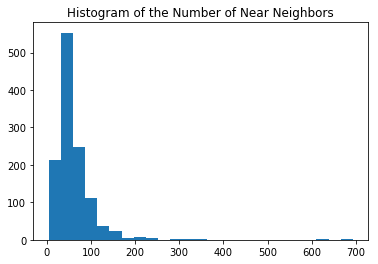

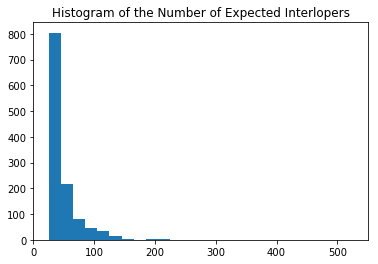

In [41]:
# Sum up satellite galaxies, expected interloper galaxies, and near neighbors
# Produce LaTeX code for a table with columns for projected radius, near neighbors, number of interlopers, number of
# satellite galaxies

sumsat = []
sumbkg = []
sumnear = []

for i in range(len(Nsat)):
    sumsat.append(np.sum(Nsat[i]))

for i in range(len(Nbkg)):
    sumbkg.append(np.sum(Nbkg[i]))
    
for i in range(len(near)):
    sumnear.append(np.sum(near[i]))

# d = {'projected radius': dist, 'number of near neighbors': nn, 'number of interlopers': sumbkg, 'number of satellites': sumsat}

# df = pd.DataFrame(data=d)

# print(tabulate(df, headers='keys', tablefmt='latex'))

meannear = np.mean(sumnear)
print("mean near neighbor is", meannear)

sdnear = np.std(sumnear)
print("standard deviation of near neighbor is", sdnear)

meanbkg = np.mean(sumbkg)
print("mean interloper is", meanbkg)

sdbkg = np.std(sumbkg)
print("standard deviation of interloper is", sdbkg)

meansat = np.mean(sumsat)
print("mean number of satellites is", meansat)

sdsat = np.std(sumsat)
print("standard deviation of satellites is", sdsat)

plt.title("Histogram of the Number of Satellite Galaxies")
plt.hist(sumsat, bins=25)
plt.show()

plt.title("Histogram of the Number of Near Neighbors")
plt.hist(sumnear, bins=25)
plt.show()


plt.title("Histogram of the Number of Expected Interlopers")
plt.hist(sumbkg, bins=25)
plt.show()

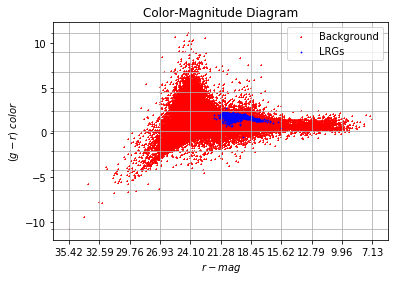

In [42]:
# CMD

fig, ax = plt.subplots()
ax.set_xticks(xedges, minor=False)
ax.set_yticks(yedges, minor=True)
ax.xaxis.grid(True, which='major')
ax.yaxis.grid(True, which='minor')

plt.scatter(rmag_BKG, color_BKG, s = 1, marker = '+', color='red', label="Background")
plt.scatter(rmag_LRG, color_LRG, s = 1, marker = '*', color='blue', label='LRGs')
plt.gca().invert_xaxis()
plt.title("Color-Magnitude Diagram")
plt.xlabel(r'$r-mag$')
plt.ylabel(r'$(g-r)$ $color$')
plt.legend(loc='upper right')
plt.show()

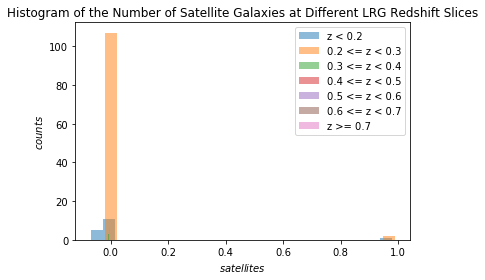

In [43]:
# Plot distribution of Nsat in different LRG redshift bins

z_lrg = np.array(z_lrg)
# print("z = ", z)
# print(type(z))

# LRG redshift from 0.0721669 <= z <= 0.846769
# bins of ~0.1

# z < 0.2
Nsat1z = Nsat[np.where(z_lrg < 0.2)]
# print(len(Nsat1))

sumsat1z = []
for i in range(len(Nsat1z)):
    sumsat1z.append(np.sum(Nsat1z[i]))

# 0.2 <= z < 0.3
Nsat2z = Nsat[np.where((z_lrg >= 0.2) & (0.3 > z_lrg))]
# print(len(Nsat2))

sumsat2z = []
for i in range(len(Nsat2z)):
    sumsat2z.append(np.sum(Nsat2z[i]))

# 0.3 <= z < 0.4
Nsat3z = Nsat[np.where((z_lrg >= 0.3) & (0.4 > z_lrg))]
# print(len(Nsat3))

sumsat3z = []
for i in range(len(Nsat3z)):
    sumsat3z.append(np.sum(Nsat3z[i]))

# 0.4 <= z < 0.5
Nsat4z = Nsat[np.where((z_lrg >= 0.4) & (0.5 > z_lrg))]
# print(len(Nsat4))

sumsat4z = []
for i in range(len(Nsat4z)):
    sumsat4z.append(np.sum(Nsat4z[i]))

# 0.5 <= z < 0.6
Nsat5z = Nsat[np.where((z_lrg >= 0.5) & (0.6 > z_lrg))]
# print(len(Nsat5))

sumsat5z = []
for i in range(len(Nsat5z)):
    sumsat5z.append(np.sum(Nsat5z[i]))

# 0.6 <= z < 0.7
Nsat6z = Nsat[np.where((z_lrg >= 0.6) & (0.7 > z_lrg))]
# print(len(Nsat6))

sumsat6z = []
for i in range(len(Nsat6z)):
    sumsat6z.append(np.sum(Nsat6z[i]))

# z >= 0.7
Nsat7z = Nsat[np.where(z_lrg >= 0.7)]
# print(len(Nsat7))

sumsat7z = []
for i in range(len(Nsat7z)):
    sumsat7z.append(np.sum(Nsat7z[i]))

plt.title("Histogram of the Number of Satellite Galaxies at Different LRG Redshift Slices")
plt.hist(sumsat1z, bins=25, alpha=0.5, label='z < 0.2')
plt.hist(sumsat2z, bins=25, alpha=0.5, label='0.2 <= z < 0.3')
plt.hist(sumsat3z, bins=25, alpha=0.5, label='0.3 <= z < 0.4')
plt.hist(sumsat4z, bins=25, alpha=0.5, label='0.4 <= z < 0.5')
plt.hist(sumsat5z, bins=25, alpha=0.5, label='0.5 <= z < 0.6')
plt.hist(sumsat6z, bins=25, alpha=0.5, label='0.6 <= z < 0.7')
plt.hist(sumsat7z, bins=25, alpha=0.5, label='z >= 0.7')
plt.xlabel(r'$satellites$')
plt.ylabel(r'$counts$')
plt.legend(loc='upper right')
plt.show()
    
# plt.title("Histogram of the Number of Satellite Galaxies at LRG z < 0.2")
# plt.hist(sumsat1z, bins=25)
# plt.xlabel(r'$satellites$')
# plt.ylabel(r'$counts$')
# plt.show()

# plt.title("Histogram of the Number of Satellite Galaxies at LRG 0.2 <= z < 0.3")
# plt.hist(sumsat2z, bins=25)
# plt.xlabel(r'$satellites$')
# plt.ylabel(r'$counts$')
# plt.show()

# plt.title("Histogram of the Number of Satellite Galaxies at LRG 0.3 <= z < 0.4")
# plt.hist(sumsat3z, bins=25)
# plt.xlabel(r'$satellites$')
# plt.ylabel(r'$counts$')
# plt.show()

# plt.title("Histogram of the Number of Satellite Galaxies at LRG 0.4 <= z < 0.5")
# plt.hist(sumsat4z, bins=25)
# plt.xlabel(r'$satellites$')
# plt.ylabel(r'$counts$')
# plt.show()

# plt.title("Histogram of the Number of Satellite Galaxies at LRG 0.5 <= z < 0.6")
# plt.hist(sumsat5z, bins=25)
# plt.xlabel(r'$satellites$')
# plt.ylabel(r'$counts$')
# plt.show()

# plt.title("Histogram of the Number of Satellite Galaxies at LRG 0.6 <= z < 0.7")
# plt.hist(sumsat6z, bins=25)
# plt.xlabel(r'$satellites$')
# plt.ylabel(r'$counts$')
# plt.show()

# plt.title("Histogram of the Number of Satellite Galaxies at LRG z >= 0.7")
# plt.hist(sumsat7z, bins=25)
# plt.xlabel(r'$satellites$')
# plt.ylabel(r'$counts$')
# plt.show()


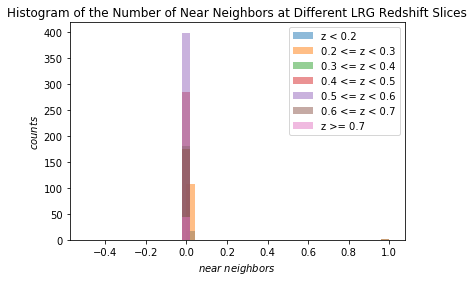

In [44]:
# Plot distribution of nn in different LRG redshift bins

near = np.array(near)
# print("z = ", z)
# print(type(z))

# LRG redshift from 0.0721669 <= z <= 0.846769
# bins of ~0.1

# z < 0.2
near1z = near[np.where(z_lrg < 0.2)]
# print(len(Nsat1))

sumnear1z = []
for i in range(len(near1z)):
    sumnear1z.append(np.sum(near1z[i]))

# 0.2 <= z < 0.3
near2z = near[np.where((z_lrg >= 0.2) & (0.3 > z_lrg))]
# print(len(Nsat2))

sumnear2z = []
for i in range(len(near2z)):
    sumnear2z.append(np.sum(near2z[i]))

# 0.3 <= z < 0.4
near3z = near[np.where((z_lrg >= 0.3) & (0.4 > z_lrg))]
# print(len(Nsat3))

sumnear3z = []
for i in range(len(near3z)):
    sumnear3z.append(np.sum(near3z[i]))

# 0.4 <= z < 0.5
near4z = near[np.where((z_lrg >= 0.4) & (0.5 > z_lrg))]
# print(len(Nsat4))

sumnear4z = []
for i in range(len(near4z)):
    sumnear4z.append(np.sum(near4z[i]))

# 0.5 <= z < 0.6
near5z = near[np.where((z_lrg >= 0.5) & (0.6 > z_lrg))]
# print(len(Nsat5))

sumnear5z = []
for i in range(len(near5z)):
    sumnear5z.append(np.sum(near5z[i]))

# 0.6 <= z < 0.7
near6z = near[np.where((z_lrg >= 0.6) & (0.7 > z_lrg))]
# print(len(Nsat6))

sumnear6z = []
for i in range(len(near6z)):
    sumnear6z.append(np.sum(near6z[i]))

# z >= 0.7
near7z = near[np.where(z_lrg >= 0.7)]
# print(len(Nsat7))

sumnear7z = []
for i in range(len(near7z)):
    sumnear7z.append(np.sum(near7z[i]))
    
    
plt.title("Histogram of the Number of Near Neighbors at Different LRG Redshift Slices")
plt.hist(sumnear1z, bins=25, alpha=0.5, label='z < 0.2')
plt.hist(sumnear2z, bins=25, alpha=0.5, label='0.2 <= z < 0.3')
plt.hist(sumnear3z, bins=25, alpha=0.5, label='0.3 <= z < 0.4')
plt.hist(sumnear4z, bins=25, alpha=0.5, label='0.4 <= z < 0.5')
plt.hist(sumnear5z, bins=25, alpha=0.5, label='0.5 <= z < 0.6')
plt.hist(sumnear6z, bins=25, alpha=0.5, label='0.6 <= z < 0.7')
plt.hist(sumnear7z, bins=25, alpha=0.5, label='z >= 0.7')
plt.xlabel(r'$near$ $neighbors$')
plt.ylabel(r'$counts$')
plt.legend(loc='upper right')
plt.show()
    
# plt.title("Histogram of the Number of Near Neighbors at LRG z < 0.2")
# plt.hist(sumnear1z, bins=25)
# plt.xlabel(r'$near$ $neighbors$')
# plt.ylabel(r'$counts$')
# plt.show()

# plt.title("Histogram of the Number of Near Neighbors at LRG 0.2 <= z < 0.3")
# plt.hist(sumnear2z, bins=25)
# plt.xlabel(r'$near$ $neighbors$')
# plt.ylabel(r'$counts$')
# plt.show()

# plt.title("Histogram of the Number of Near Neighbors at LRG 0.3 <= z < 0.4")
# plt.hist(sumnear3z, bins=25)
# plt.xlabel(r'$near$ $neighbors$')
# plt.ylabel(r'$counts$')
# plt.show()

# plt.title("Histogram of the Number of Near Neighbors at LRG 0.4 <= z < 0.5")
# plt.hist(sumnear4z, bins=25)
# plt.xlabel(r'$near$ $neighbors$')
# plt.ylabel(r'$counts$')
# plt.show()

# plt.title("Histogram of the Number of Near Neighbors at LRG 0.5 <= z < 0.6")
# plt.hist(sumnear5z, bins=25)
# plt.xlabel(r'$near$ $neighbors$')
# plt.ylabel(r'$counts$')
# plt.show()

# plt.title("Histogram of the Number of Near Neighbors at LRG 0.6 <= z < 0.7")
# plt.hist(sumnear6z, bins=25)
# plt.xlabel(r'$near$ $neighbors$')
# plt.ylabel(r'$counts$')
# plt.show()

# plt.title("Histogram of the Number of Near Neighbors at LRG z >= 0.7")
# plt.hist(sumnear7z, bins=25)
# plt.xlabel(r'$near$ $neighbors$')
# plt.ylabel(r'$counts$')
# plt.show()


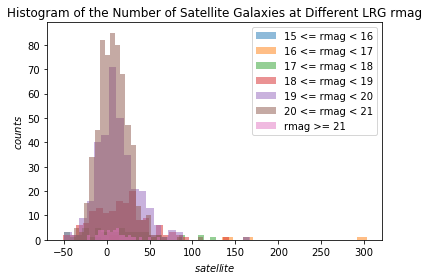

In [45]:
# Plot distribution of Nsat in different LRG rmag bins

rmag_LRG = np.array(rmag_LRG)
# print("z = ", z)
# print(type(z))

# LRG rmag from 22.3639 <= rmag <= 15.8399
# bins of ~1 mag

# 15 <= rmag < 16
Nsat1r = Nsat[np.where((rmag_LRG >= 15.) & (16. > rmag_LRG))]
# print(len(Nsat1))

sumsat1r = []
for i in range(len(Nsat1r)):
    sumsat1r.append(np.sum(Nsat1r[i]))

# 16 <= rmag < 17
Nsat2r = Nsat[np.where((rmag_LRG >= 16.) & (17. > rmag_LRG))]
# print(len(Nsat2))

sumsat2r = []
for i in range(len(Nsat2r)):
    sumsat2r.append(np.sum(Nsat2r[i]))

# 17 <= rmag < 18
Nsat3r = Nsat[np.where((rmag_LRG >= 17.) & (18. > rmag_LRG))]
# print(len(Nsat3))

sumsat3r = []
for i in range(len(Nsat3r)):
    sumsat3r.append(np.sum(Nsat3r[i]))

# 18 <= rmag < 19
Nsat4r = Nsat[np.where((rmag_LRG >= 18.) & (19. > rmag_LRG))]
# print(len(Nsat4))

sumsat4r = []
for i in range(len(Nsat4r)):
    sumsat4r.append(np.sum(Nsat4r[i]))

# 19 <= rmag < 20
Nsat5r = Nsat[np.where((rmag_LRG >= 19.) & (20. > rmag_LRG))]
# print(len(Nsat5))

sumsat5r = []
for i in range(len(Nsat5r)):
    sumsat5r.append(np.sum(Nsat5r[i]))

# 20 <= rmag < 21
Nsat6r = Nsat[np.where((rmag_LRG >= 20.) & (21. > rmag_LRG))]
# print(len(Nsat6))

sumsat6r = []
for i in range(len(Nsat6r)):
    sumsat6r.append(np.sum(Nsat6r[i]))

# rmag >= 21
Nsat7r = Nsat[np.where(rmag_LRG >= 21.)]
# print(len(Nsat7))

sumsat7r = []
for i in range(len(Nsat7r)):
    sumsat7r.append(np.sum(Nsat7r[i]))
    

plt.title("Histogram of the Number of Satellite Galaxies at Different LRG rmag")
plt.hist(sumsat1r, bins=25, alpha=0.5, label='15 <= rmag < 16')
plt.hist(sumsat2r, bins=25, alpha=0.5, label='16 <= rmag < 17')
plt.hist(sumsat3r, bins=25, alpha=0.5, label='17 <= rmag < 18')
plt.hist(sumsat4r, bins=25, alpha=0.5, label='18 <= rmag < 19')
plt.hist(sumsat5r, bins=25, alpha=0.5, label='19 <= rmag < 20')
plt.hist(sumsat6r, bins=25, alpha=0.5, label='20 <= rmag < 21')
plt.hist(sumsat7r, bins=25, alpha=0.5, label='rmag >= 21')
plt.xlabel(r'$satellite$')
plt.ylabel(r'$counts$')
plt.legend(loc='upper right')
plt.show()
    
# plt.title("Histogram of the Number of Satellite Galaxies at LRG 15 <= rmag < 16")
# plt.hist(sumsat1r, bins=25, color='red')
# plt.xlabel(r'$satellites$')
# plt.ylabel(r'$counts$')
# plt.show()

# plt.title("Histogram of the Number of Satellite Galaxies at LRG 16 <= rmag < 17")
# plt.hist(sumsat2r, bins=25, color='red')
# plt.xlabel(r'$satellites$')
# plt.ylabel(r'$counts$')
# plt.show()

# plt.title("Histogram of the Number of Satellite Galaxies at LRG  17 <= rmag < 18")
# plt.hist(sumsat3r, bins=25, color='red')
# plt.xlabel(r'$satellites$')
# plt.ylabel(r'$counts$')
# plt.show()

# plt.title("Histogram of the Number of Satellite Galaxies at LRG 18 <= rmag < 19")
# plt.hist(sumsat4r, bins=25, color='red')
# plt.xlabel(r'$satellites$')
# plt.ylabel(r'$counts$')
# plt.show()

# plt.title("Histogram of the Number of Satellite Galaxies at LRG 19 <= rmag < 20")
# plt.hist(sumsat5r, bins=25, color='red')
# plt.xlabel(r'$satellites$')
# plt.ylabel(r'$counts$')
# plt.show()

# plt.title("Histogram of the Number of Satellite Galaxies at LRG 20 <= rmag < 21")
# plt.hist(sumsat6r, bins=25, color='red')
# plt.xlabel(r'$satellites$')
# plt.ylabel(r'$counts$')
# plt.show()

# plt.title("Histogram of the Number of Satellite Galaxies at LRG rmag >= 21")
# plt.hist(sumsat7r, bins=25, color='red')
# plt.xlabel(r'$satellites$')
# plt.ylabel(r'$counts$')
# plt.show()


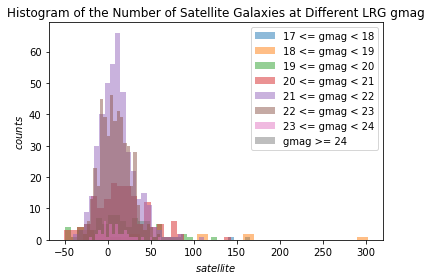

In [46]:
# Plot distribution of Nsat in different LRG gmag bins

gmag_LRG = np.array(gmag_LRG)
# print("z = ", z)
# print(type(z))

# LRG gmag from 25.1832 <= rmag <= 17.0737
# bins of ~1 mag

# 17 <= gmag < 18
Nsat1g = Nsat[np.where((gmag_LRG >= 17.) & (18. > gmag_LRG))]
# print(len(Nsat1))

sumsat1g = []
for i in range(len(Nsat1g)):
    sumsat1g.append(np.sum(Nsat1g[i]))

# 18 <= gmag < 19
Nsat2g = Nsat[np.where((gmag_LRG >= 18.) & (19. > gmag_LRG))]
# print(len(Nsat2))

sumsat2g = []
for i in range(len(Nsat2g)):
    sumsat2g.append(np.sum(Nsat2g[i]))

# 19 <= gmag < 20
Nsat3g = Nsat[np.where((gmag_LRG >= 19.) & (20. > gmag_LRG))]
# print(len(Nsat3))

sumsat3g = []
for i in range(len(Nsat3g)):
    sumsat3g.append(np.sum(Nsat3g[i]))

# 20 <= gmag < 21
Nsat4g = Nsat[np.where((gmag_LRG >= 20.) & (21. > gmag_LRG))]
# print(len(Nsat4))

sumsat4g = []
for i in range(len(Nsat4g)):
    sumsat4g.append(np.sum(Nsat4g[i]))

# 21 <= gmag < 22
Nsat5g = Nsat[np.where((gmag_LRG >= 21.) & (22. > gmag_LRG))]
# print(len(Nsat5))

sumsat5g = []
for i in range(len(Nsat5g)):
    sumsat5g.append(np.sum(Nsat5g[i]))

# 22 <= gmag < 23
Nsat6g = Nsat[np.where((gmag_LRG >= 22.) & (23. > gmag_LRG))]
# print(len(Nsat6))

sumsat6g = []
for i in range(len(Nsat6g)):
    sumsat6g.append(np.sum(Nsat6g[i]))
    
# 23 <= gmag < 24
Nsat7g = Nsat[np.where((gmag_LRG >= 23.) & (24. > gmag_LRG))]
# print(len(Nsat7))

sumsat7g = []
for i in range(len(Nsat7g)):
    sumsat7g.append(np.sum(Nsat7g[i]))

# gmag >= 24
Nsat8g = Nsat[np.where(gmag_LRG >= 24)]
# print(len(Nsat8))

sumsat8g = []
for i in range(len(Nsat8g)):
    sumsat8g.append(np.sum(Nsat8g[i]))
    

plt.title("Histogram of the Number of Satellite Galaxies at Different LRG gmag")
plt.hist(sumsat1g, bins=25, alpha=0.5, label='17 <= gmag < 18')
plt.hist(sumsat2g, bins=25, alpha=0.5, label='18 <= gmag < 19')
plt.hist(sumsat3g, bins=25, alpha=0.5, label='19 <= gmag < 20')
plt.hist(sumsat4g, bins=25, alpha=0.5, label='20 <= gmag < 21')
plt.hist(sumsat5g, bins=25, alpha=0.5, label='21 <= gmag < 22')
plt.hist(sumsat6g, bins=25, alpha=0.5, label='22 <= gmag < 23')
plt.hist(sumsat7g, bins=25, alpha=0.5, label='23 <= gmag < 24')
plt.hist(sumsat8g, bins=25, alpha=0.5, label='gmag >= 24')
plt.xlabel(r'$satellite$')
plt.ylabel(r'$counts$')
plt.legend(loc='upper right')
plt.show()

# plt.title("Histogram of the Number of Satellite Galaxies at LRG 17 <= gmag < 18")
# plt.hist(sumsat1g, bins=25, color='g')
# plt.xlabel(r'$satellites$')
# plt.ylabel(r'$counts$')
# plt.show()

# plt.title("Histogram of the Number of Satellite Galaxies at LRG 18 <= gmag < 19")
# plt.hist(sumsat2g, bins=25, color='g')
# plt.xlabel(r'$satellites$')
# plt.ylabel(r'$counts$')
# plt.show()

# plt.title("Histogram of the Number of Satellite Galaxies at LRG  19 <= gmag < 20")
# plt.hist(sumsat3g, bins=25, color='g')
# plt.xlabel(r'$satellites$')
# plt.ylabel(r'$counts$')
# plt.show()

# plt.title("Histogram of the Number of Satellite Galaxies at LRG 20 <= gmag < 21")
# plt.hist(sumsat4g, bins=25, color='g')
# plt.xlabel(r'$satellites$')
# plt.ylabel(r'$counts$')
# plt.show()

# plt.title("Histogram of the Number of Satellite Galaxies at LRG 21 <= gmag < 22")
# plt.hist(sumsat5g, bins=25, color='g')
# plt.xlabel(r'$satellites$')
# plt.ylabel(r'$counts$')
# plt.show()

# plt.title("Histogram of the Number of Satellite Galaxies at LRG 22 <= gmag < 23")
# plt.hist(sumsat6g, bins=25, color='g')
# plt.xlabel(r'$satellites$')
# plt.ylabel(r'$counts$')
# plt.show()

# plt.title("Histogram of the Number of Satellite Galaxies at LRG 23 <= gmag < 24")
# plt.hist(sumsat7g, bins=25, color='g')
# plt.xlabel(r'$satellites$')
# plt.ylabel(r'$counts$')
# plt.show()

# plt.title("Histogram of the Number of Satellite Galaxies at LRG gmag >= 24")
# plt.hist(sumsat8g, bins=25, color='g')
# plt.xlabel(r'$satellites$')
# plt.ylabel(r'$counts$')
# plt.show()


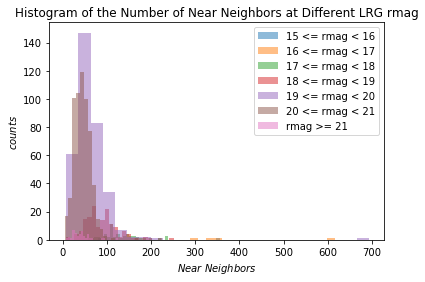

In [47]:
# Plot distribution of nn in different LRG rmag bins

rmag_LRG = np.array(rmag_LRG)
# print("z = ", z)
# print(type(z))

# LRG rmag from 22.3639 <= rmag <= 15.8399
# bins of ~1 mag

# 15 <= rmag < 16
near1r = near[np.where((rmag_LRG >= 15.) & (16. > rmag_LRG))]
# print(len(Nsat1))

sumnear1r = []
for i in range(len(near1r)):
    sumnear1r.append(np.sum(near1r[i]))

# 16 <= rmag < 17
near2r = near[np.where((rmag_LRG >= 16.) & (17. > rmag_LRG))]
# print(len(Nsat2))

sumnear2r = []
for i in range(len(near2r)):
    sumnear2r.append(np.sum(near2r[i]))

# 17 <= rmag < 18
near3r = near[np.where((rmag_LRG >= 17.) & (18. > rmag_LRG))]
# print(len(Nsat3))

sumnear3r = []
for i in range(len(near3r)):
    sumnear3r.append(np.sum(near3r[i]))

# 18 <= rmag < 19
near4r = near[np.where((rmag_LRG >= 18.) & (19. > rmag_LRG))]
# print(len(Nsat4))

sumnear4r = []
for i in range(len(near4r)):
    sumnear4r.append(np.sum(near4r[i]))

# 19 <= rmag < 20
near5r = near[np.where((rmag_LRG >= 19.) & (20. > rmag_LRG))]
# print(len(Nsat5))

sumnear5r = []
for i in range(len(near5r)):
    sumnear5r.append(np.sum(near5r[i]))

# 20 <= rmag < 21
near6r = near[np.where((rmag_LRG >= 20.) & (21. > rmag_LRG))]
# print(len(Nsat6))

sumnear6r = []
for i in range(len(near6r)):
    sumnear6r.append(np.sum(near6r[i]))

# rmag >= 21
near7r = near[np.where(rmag_LRG >= 21.)]
# print(len(Nsat7))

sumnear7r = []
for i in range(len(near7r)):
    sumnear7r.append(np.sum(near7r[i]))
    
    
plt.title("Histogram of the Number of Near Neighbors at Different LRG rmag")
plt.hist(sumnear1r, bins=25, alpha=0.5, label='15 <= rmag < 16')
plt.hist(sumnear2r, bins=25, alpha=0.5, label='16 <= rmag < 17')
plt.hist(sumnear3r, bins=25, alpha=0.5, label='17 <= rmag < 18')
plt.hist(sumnear4r, bins=25, alpha=0.5, label='18 <= rmag < 19')
plt.hist(sumnear5r, bins=25, alpha=0.5, label='19 <= rmag < 20')
plt.hist(sumnear6r, bins=25, alpha=0.5, label='20 <= rmag < 21')
plt.hist(sumnear7r, bins=25, alpha=0.5, label='rmag >= 21')
plt.xlabel(r'$Near$ $Neighbors$')
plt.ylabel(r'$counts$')
plt.legend(loc='upper right')
plt.show()
    
    
# plt.title("Histogram of the Number of Near Neighbors at LRG 15 <= rmag < 16")
# plt.hist(sumnear1r, bins=25, color='red')
# plt.xlabel(r'$near$ $neighbors$')
# plt.ylabel(r'$counts$')
# plt.show()

# plt.title("Histogram of the Number of Near Neighbors at LRG 16 <= rmag < 17")
# plt.hist(sumnear2r, bins=25, color='red')
# plt.xlabel(r'$near$ $neighbors$')
# plt.ylabel(r'$counts$')
# plt.show()

# plt.title("Histogram of the Number of Near Neighbors at LRG  17 <= rmag < 18")
# plt.hist(sumnear3r, bins=25, color='red')
# plt.xlabel(r'$near$ $neighbors$')
# plt.ylabel(r'$counts$')
# plt.show()

# plt.title("Histogram of the Number of Near Neighbors at LRG 18 <= rmag < 19")
# plt.hist(sumnear4r, bins=25, color='red')
# plt.xlabel(r'$near$ $neighbors$')
# plt.ylabel(r'$counts$')
# plt.show()

# plt.title("Histogram of the Number of Near Neighbors at LRG 19 <= rmag < 20")
# plt.hist(sumnear5r, bins=25, color='red')
# plt.xlabel(r'$near$ $neighbors$')
# plt.ylabel(r'$counts$')
# plt.show()

# plt.title("Histogram of the Number of Near Neighbors at LRG 20 <= rmag < 21")
# plt.hist(sumnear6r, bins=25, color='red')
# plt.xlabel(r'$near$ $neighbors$')
# plt.ylabel(r'$counts$')
# plt.show()

# plt.title("Histogram of the Number of Near Neighbors at LRG rmag >= 21")
# plt.hist(sumnear7r, bins=25, color='red')
# plt.xlabel(r'$near$ $neighbors$')
# plt.ylabel(r'$counts$')
# plt.show()


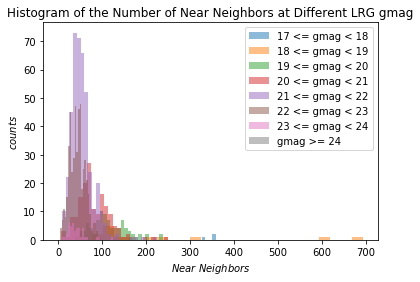

In [48]:
# Plot distribution of nn in different LRG gmag bins

gmag_LRG = np.array(gmag_LRG)
# print("z = ", z)
# print(type(z))

# LRG gmag from 25.1832 <= rmag <= 17.0737
# bins of ~1 mag

# 17 <= gmag < 18
near1g = near[np.where((gmag_LRG >= 17.) & (18. > gmag_LRG))]
# print(len(Nsat1))

sumnear1g = []
for i in range(len(near1g)):
    sumnear1g.append(np.sum(near1g[i]))

# 18 <= gmag < 19
near2g = near[np.where((gmag_LRG >= 18.) & (19. > gmag_LRG))]
# print(len(near2g))

sumnear2g = []
for i in range(len(near2g)):
    sumnear2g.append(np.sum(near2g[i]))
# print(len(sumnear2g))
    
# 19 <= gmag < 20
near3g = near[np.where((gmag_LRG >= 19.) & (20. > gmag_LRG))]
# print(len(Nsat3))

sumnear3g = []
for i in range(len(near3g)):
    sumnear3g.append(np.sum(near3g[i]))

# 20 <= gmag < 21
near4g = near[np.where((gmag_LRG >= 20.) & (21. > gmag_LRG))]
# print(len(Nsat4))

sumnear4g = []
for i in range(len(near4g)):
    sumnear4g.append(np.sum(near4g[i]))

# 21 <= gmag < 22
near5g = near[np.where((gmag_LRG >= 21.) & (22. > gmag_LRG))]
# print(len(Nsat5))

sumnear5g = []
for i in range(len(near5g)):
    sumnear5g.append(np.sum(near5g[i]))

# 22 <= gmag < 23
near6g = near[np.where((gmag_LRG >= 22.) & (23. > gmag_LRG))]
# print(len(Nsat6))

sumnear6g = []
for i in range(len(near6g)):
    sumnear6g.append(np.sum(near6g[i]))
    
# 23 <= gmag < 24
near7g = near[np.where((gmag_LRG >= 23.) & (24. > gmag_LRG))]
# print(len(Nsat7))

sumnear7g = []
for i in range(len(near7g)):
    sumnear7g.append(np.sum(near7g[i]))

# gmag >= 24
near8g = near[np.where(gmag_LRG >= 24)]
# print(len(Nsat8))

sumnear8g = []
for i in range(len(near8g)):
    sumnear8g.append(np.sum(near8g[i]))
    

plt.title("Histogram of the Number of Near Neighbors at Different LRG gmag")
plt.hist(sumnear1g, bins=25, alpha=0.5, label='17 <= gmag < 18')
plt.hist(sumnear2g, bins=25, alpha=0.5, label='18 <= gmag < 19')
plt.hist(sumnear3g, bins=25, alpha=0.5, label='19 <= gmag < 20')
plt.hist(sumnear4g, bins=25, alpha=0.5, label='20 <= gmag < 21')
plt.hist(sumnear5g, bins=25, alpha=0.5, label='21 <= gmag < 22')
plt.hist(sumnear6g, bins=25, alpha=0.5, label='22 <= gmag < 23')
plt.hist(sumnear7g, bins=25, alpha=0.5, label='23 <= gmag < 24')
plt.hist(sumnear8g, bins=25, alpha=0.5, label='gmag >= 24')
plt.xlabel(r'$Near$ $Neighbors$')
plt.ylabel(r'$counts$')
plt.legend(loc='upper right')
plt.show()
    
    
# plt.title("Histogram of the Number of Near Neighbors at LRG 17 <= gmag < 18")
# plt.hist(sumnear1g, bins=25, color='g')
# plt.xlabel(r'$near$ $neighbors$')
# plt.ylabel(r'$counts$')
# plt.show()

# plt.title("Histogram of the Number of Near Neighbors at LRG 18 <= gmag < 19")
# plt.hist(sumnear2g, bins=25, color='g')
# plt.xlabel(r'$near$ $neighbors$')
# plt.ylabel(r'$counts$')
# plt.show()

# plt.title("Histogram of the Number of Near Neighbors at LRG  19 <= gmag < 20")
# plt.hist(sumnear3g, bins=25, color='g')
# plt.xlabel(r'$near$ $neighbors$')
# plt.ylabel(r'$counts$')
# plt.show()

# plt.title("Histogram of the Number of Near Neighbors at LRG 20 <= gmag < 21")
# plt.hist(sumnear4g, bins=25, color='g')
# plt.xlabel(r'$near$ $neighbors$')
# plt.ylabel(r'$counts$')
# plt.show()

# plt.title("Histogram of the Number of Near Neighbors at LRG 21 <= gmag < 22")
# plt.hist(sumnear5g, bins=25, color='g')
# plt.xlabel(r'$near$ $neighbors$')
# plt.ylabel(r'$counts$')
# plt.show()

# plt.title("Histogram of the Number of Near Neighbors at LRG 22 <= gmag < 23")
# plt.hist(sumnear6g, bins=25, color='g')
# plt.xlabel(r'$near$ $neighbors$')
# plt.ylabel(r'$counts$')
# plt.show()

# plt.title("Histogram of the Number of Near Neighbors at LRG 23 <= gmag < 24")
# plt.hist(sumnear7g, bins=25, color='g')
# plt.xlabel(r'$near$ $neighbors$')
# plt.ylabel(r'$counts$')
# plt.show()

# plt.title("Histogram of the Number of Near Neighbors at LRG gmag >= 24")
# plt.hist(sumnear8g, bins=25, color='g')
# plt.xlabel(r'$near$ $neighbors$')
# plt.ylabel(r'$counts$')
# plt.show()




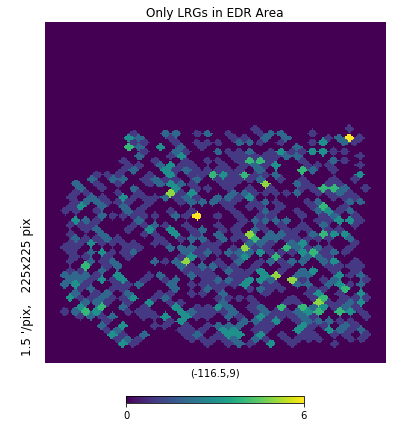

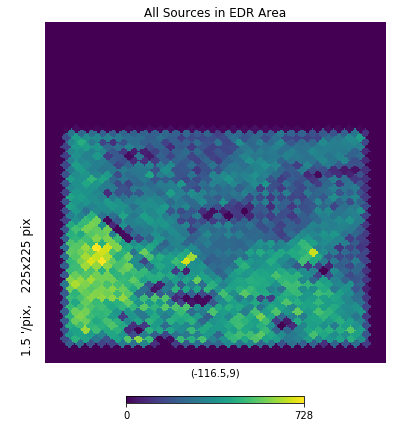

In [34]:
# Use HEALPix/Healpy to plot of sources over the sky

# add flip='geo' to make it look like the RA-Dec plot

%matplotlib inline

theta, phi = np.radians(90-dec_lrg), np.radians(ra_lrg)
nside = 512
npixel= hp.nside2npix(nside)
m = hp.ang2pix(nside, theta, phi)
map_ = np.bincount(m, minlength=npixel)
hp.gnomview(map_,rot=(-116.5,9.),xsize=225,title="Only LRGs in EDR Area")

ra = np.concatenate([ra_lrg, ra_BKG])
dec = np.concatenate([dec_lrg, dec_BKG])

theta, phi = np.radians(90-dec), np.radians(ra)
nside = 512
npixel= hp.nside2npix(nside)
m = hp.ang2pix(nside, theta, phi)
map_ = np.bincount(m, minlength=npixel)
hp.gnomview(map_,rot=(-116.5,9.),xsize=225,title="All Sources in EDR Area")